# Machine Learning for KickStarter Success Prediction

## Julie Zhang

# Background & Motivation¶


Kickstarter is an American public benefit corporation that maintains a global crowdfunding platform focused on creativity. The company's stated mission is to "help bring creative projects to life". As of December 2019, Kickstarter has received more than $4.6 billion in pledges from 17.2 million backers to fund 445,000 projects, including projects from many different industries, such as films, music, stage shows, comics, journalism, video games, technology, publishing, and food-related projects. Kickstarter is one of a number of crowdfunding platforms for gathering money from the public, which circumvents traditional avenues of investment. Project creators choose a deadline and a minimum funding goal. If the goal is not met by the deadline, no funds are collected. This acts like a kind of assurance contract for all stakeholders. 

Kickstarter applies a 5% fee on the total amount of the funds raised as their source of income. However, there is no guarantee that people who post projects on Kickstarter will deliver on their projects, use the money to implement their projects, or that the completed projects will meet backers' expectations. Projects might also fail even after a successful fundraising campaign when creators underestimate the total costs required or technical difficulties to be overcome. Thus, to know what factors contributes to the success of a project is of great importance to all stakeholders. 

According to the data polished by Kickstarter, as of December 4, 2019, there were 469,286 launched projects (3,524 in progress), with a success rate of 37.45%. The total amount pledged was $4,690,286,673. The objective of this project is to find out what contributes to the success of a project so that both participants and the company can use those indicators as references before making any investment decisions. We collected data of Kickstarter in 2018 used the first 10,000 rows of data to analyze which features can be used to predict the final state (success/fail) of a project.

# Discussion about Questions¶

Business question: Is this specific product worth investing?

Statistical question: which features can be used to predict final(success/fail) state of a specific product/project?

The statistical question is particularly useful because it reveals which features are useful in terms of success rate prediction and consequently stakeholders can use these features to do their risk assessment before investing.
However, this statistical question does not answer the business question directly. Even though the features are correlated with the final success rate, these features do not guarantee the final result. A more complicated algorithm may be required for more accurate prediction.

# Exploratory data analysis

### Starter Codes:

In [20]:
import pandas as pd; from datetime import datetime
from sklearn.dummy import DummyClassifier;from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer;from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline;from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV;from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC;from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report,confusion_matrix
from sklearn.compose import make_column_transformer;import numpy as np
from scipy.stats import lognorm, loguniform, randint,uniform
from sklearn.neighbors import KNeighborsClassifier
import altair as alt;import pprint as pp;from sklearn.metrics import classification_report

### Data Cleaning

In [17]:
# load data +cleaning date column
data = pd.read_csv('ks-projects-201801.csv')
data = data[0:10000]
def extract_launched(s):
    return s[0:10]
data['launched'] = data.launched.apply(extract_launched)
# comment
data['launched'] = pd.to_datetime(data['launched'])
data['deadline'] = pd.to_datetime(data['deadline'])
data['days_in_advance'] = data['deadline']- data['launched']
new=[]
for i in range(0,10000):
    new.append(data['days_in_advance'][i].days)
data['days_in_advance'] = new

# cleaning category column
top_20_category=data['category'].value_counts()[:20] #keep top 20 of the category column and rest as 'other'
tmp=[]
for index, val in top_20_category.iteritems():
    tmp.append(index)
tmp
for index, row in data.iterrows():
    if(row['category'] not in tmp):
        row['category'] = 'other'


# cleaning target column
data.loc[data['state'] == "successful", 'target'] = 'successful' 
data.loc[data['state'] != "successful", 'target'] = 'unsuccessful'
data = data.drop(columns=['ID','name','launched','deadline','state','pledged','usd pledged','goal'])

In this step, we dropped columns that are irrelevant or redundant, and added columns that could potentially do well in describing the feature of the projects.
We kept columns:<br>
"category" and "main_category", which explain the nature of the project; 
<br>"currency", "country" which describe the geographical features of the project; 
<br>"backers" (number of supporters),"usd_pledged_real", "usd_goal_real" and "days_in_advance" to describe the features of the fund-raising.

###  Train test split

In [22]:
# train and test split
X=data.drop(columns=['target'])
y=data["target"]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=2021)

### Exploratory Data Analysis

In [18]:
##EDA for numerical variables
num_variable=['backers','usd_pledged_real','usd_goal_real','days_in_advance']
cate_variable=['category','main_category','currency','country']
y_list=list(y_train)
train_df=X_train.assign(target = y_list)
alt.data_transformers.disable_max_rows()

for i,col in enumerate(num_variable):
    col_min=min(X_train[col])
    col_max=max(X_train[col])
    col_median=np.nanmedian(X_train[col])
    col_mean=np.nanmean(X_train[col])
    print(col);print("min:",col_min);print("max:",col_max);print("median:",col_median);print("mean:",col_mean)
    standard=max(col_median,col_mean)
    maxbin=min(col_max,standard*2)
    histogram_overlayed = alt.Chart(train_df.sort_values(by='target')).mark_bar(opacity=0.6).encode(
    alt.X(col, bin=alt.Bin(extent=[col_min, maxbin], maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('target:N')).properties(
    title= 'Distribution for separate target values',width=700,
    height=200)
    histogram_overlayed.display()

backers
min: 0
max: 36863
median: 12.0
mean: 103.250375


alt.Chart(...)

usd_pledged_real
min: 0.0
max: 5020667.05
median: 650.0
mean: 9895.064235000002


alt.Chart(...)

usd_goal_real
min: 0.91
max: 20000000.0
median: 5352.425
mean: 32634.371733750002


alt.Chart(...)

days_in_advance
min: 1
max: 14867
median: 30.0
mean: 36.092375


alt.Chart(...)

In [7]:
for i,col in enumerate(cate_variable):
    if len(data[col].unique())>15:
        toplist=train_df[col].value_counts()[:15].index.tolist()
        subset=train_df[train_df[col].isin(toplist)]
        col_df=subset.groupby([col,"target"]).count().iloc[:, 0]
        col_df=col_df.to_frame()
        col_df = col_df.T
        print("information for:",col)
        display(col_df)
    else:
        col_df=train_df.groupby([col,"target"]).count().iloc[:, 0]
        col_df=col_df.to_frame()
        col_df = col_df.T
        print("information for:",col)
        display(col_df)

information for: category


category             Art              Documentary                 Fashion  \
target        successful unsuccessful  successful unsuccessful successful   
main_category         81           86         123          227         45   

category                      Fiction              Film & Video               \
target        unsuccessful successful unsuccessful   successful unsuccessful   
main_category          141         40          159           65          160   

category       ...       Rock                  Shorts               \
target         ... successful unsuccessful successful unsuccessful   
main_category  ...         79           72        147          130   

category      Tabletop Games                 Theater              Video Games  \
target            successful unsuccessful successful unsuccessful  successful   
main_category            181          129         82           63          56   

category                    
target        unsuccessful  
main_category          213  

[1 rows x 30 columns]

information for: main_category


main_category        Art                  Comics                  Crafts  \
target        successful unsuccessful successful unsuccessful successful   
category             253          354        123           99         40   

main_category                   Dance                  Design               \
target        unsuccessful successful unsuccessful successful unsuccessful   
category               140         49           27        226          435   

main_category  ...      Music              Photography               \
target         ... successful unsuccessful  successful unsuccessful   
category       ...        530          579          66          155   

main_category Publishing              Technology                 Theater  \
target        successful unsuccessful successful unsuccessful successful   
category             236          569        134          530        134   

main_category               
target        unsuccessful  
category                94  

[1 rows x 30 columns]

information for: currency


currency        AUD                     CAD                     CHF  \
target   successful unsuccessful successful unsuccessful successful   
category         31          119         93          248          8   

currency                     DKK                     EUR               ...  \
target   unsuccessful successful unsuccessful successful unsuccessful  ...   
category           10          3           11         90          302  ...   

currency        NOK                     NZD                     SEK  \
target   successful unsuccessful successful unsuccessful successful   
category          3            7          7           15         14   

currency                     SGD                     USD               
target   unsuccessful successful unsuccessful successful unsuccessful  
category           29          4            5       2320         3859  

[1 rows x 27 columns]

information for: country


country          AU                      CA                      DE  \
target   successful unsuccessful successful unsuccessful successful   
category         31          117         93          242         22   

country                       ES                      FR               ...  \
target   unsuccessful successful unsuccessful successful unsuccessful  ...   
category           67         16           32         20           52  ...   

country        N,0"                      NL                      NZ  \
target   successful unsuccessful successful unsuccessful successful   
category          4           71         13           50          7   

country                       SE                      US               
target   unsuccessful successful unsuccessful successful unsuccessful  
category           15         14           28       2316         3811  

[1 rows x 30 columns]

### Observations
For the numerical variables, here we list the observations of their behaviors:

| Variable name | Behavior | 
| :- |: ------------- |
| backers | Obvious split among the two targets, with successful ones having over 5 backers and unsuccessful ones having less than 5 backers. | 
| usd_pledged_reale |  Strong split among the two targets, with successful ones pledging over 800 USD and unsuccessful ones pledging less than 800 USD. | 
| usd_goal_real | Visible split among the two targets, with successful ones having a higher chance to target less than 5000 USD and unsuccessful ones having a higher chance to target more than 5000 USD. | 
| days_in_advance | Bimodal distribution with 30 and 60 as two peaks. Visible split that successful ones more likely to go for 30 while unsuccessful ones 60. | 

For the categorical variables, we can observe different success ratios in different categories of each variable, indicating they could be useful in predicting the final state of the project.

## Methodology for developing models:

### data cleaning

Our group first did some data cleaning on the original dataset, before any feature-processing is performed.

1. Date columns: In the original dataset, we have two columns: 'deadline' indicating the due date of a project, 'lanuched' indicating the start datetime for this project, both stored as string.If we treat this two columns simply as categorical objects, we will lose their original meaning and we have to deal with large cardinality. Instead, we first converted this two columns to contain python datetime objects, and drop hh:mm:ss to make it more consistent; then we take the difference between this two dates and get a timedelta object called days_in_advance, which represents how early does the project starts before the deadline. Lastly we convert this variable to integer.


2. 'category' column: In the original dataset, this column has 150+ cardinality, which makes it complex for both building and interpreting a model. It is important to notice that we also have another column called 'main_category'. After carefully comparing 'category' and 'main_category' we found that the latter provides summarization on the former; but it is not appropriate to completely drop 'category' because it provides detailed specification on 'main_category' and we would lose information if we do so. Our group find a compromise: we keep top 20 categories based on frequency and changed the rest to 'other'.


3. target column: We only focus on project features contributing to project failure/success, so we encode target value other than 'successful'(in-progress,canceled,failed) to 'unsucessful'. In this way, we simplified the target column to be binary, to prepare for classification.


4. Drop irrelevant columns: We immediately we dropped ID and name because they provide meaningless information but identifying the project. Secondly we dropped'launched','deadline','state' because these three columns has already been encoded before into new varaibles on our own interest. After this, we checked original source of the data and found that pledged and goal has their monetary equivalent columns usd_pledged_real and usd_goal_real, which are the two final attributes that we desire. For example if we keep both pledged and also its usd equivalent, we are essentailly including the same information.


5. size of dataset. Our dataset has 380K observations stored, and it takes long time for data visualization via histogram and building certain classfication models such as SVC, whose complexity is O($n^2$*$m$), where n is number of observations and m is the number of columns. The magitude of this dataset harms execution speed, model interpretation and result reproducibility; to solve this, we only include the first 10000 rows of the dataset.





### data pre-processing:

In [8]:
# building pre-processing pipelines
num_processor = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_processor = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))
pre_processor = make_column_transformer((num_processor,['backers','usd_pledged_real','usd_goal_real','days_in_advance']),
                                        (cat_processor,['category','main_category','currency','country',]))

We used scaling on every numeric variable to address different magnitudes across numerical columns. In our cleaned dataset, most of the data entries in usd_goal_real are above 10K, while numbers in the other three numeric columns rarely exceeds hundreds. Scaling should be performed in order to avoid the dominance of usd_goal_real and diminishing of the original influence of other numeric columns. As a general strategy,we used Onehot encoding on every categorical variable. We used SimpleImputer on all feature columns to fill in missing values: mean for numerical, and constant for categorical. 
Lastly we assign these processors accordingly to build a columnTransformer, and built a pipeline for further use. Summarized as the following table:

| Feature | Transformation |
| --- | ----------- | 
| category | imputation, Onehot encoding |
| main_category | imputation, Onehot encoding |
| currency | imputation, Onehot encoding |
| backers | imputation, scaling |
| country | imputation, Onehot encoding |
| usd_pledged_real | imputation, scaling |
| usd_goal_real | imputation, scaling |
| days_in_advance | imputation, scaling |



### Hyper-parameter tuning:

Our group built one DummyClassifier as the baseline model to compare as well as four other candidate models, namely K-NN classifier, Logistic Regression,DecisionTreeClassifier and a support vector machine classifier(SVC). We combined each classification model with the pre-processor pipeline, and fit it on training set. 

Instead of choosing hyperparameters manualy, we made use of RandomizedSearchCV to find optimal value(s) of corresponding hyperparameters to increase accuracy, reduce human work and avoid overfitting. We included model name, hyper-parameter(s) that we are optimizing, feasible ranges and the best parameter chosen.

| Model| parameter_name(s) |parameter_grid|best_parameter|
| --- | ----------- | ------|-------|
| KNN | n_neighbors |range(0,100)|9
| Losgistic Regression | C |loguniform(0.01,100)|97.49293061113849
| DecisionTreeClassifier | max_depth |range(0,100)|8
| SVC | C,gamma |loguniform(0.01,100)|C= 97.49293061113849,gamma =0.032557383985590826


## Model Testing

### Baseline model: DummyClassifier

In [9]:
pipe_dummy_clf = make_pipeline(pre_processor, DummyClassifier(strategy='stratified',random_state=2021))
pipe_dummy_clf.fit(X_train,y_train)
print(pipe_dummy_clf.score(X_train,y_train))
print(pipe_dummy_clf.score(X_test,y_test))

0.53725
0.5205


### Model: K-nearest neighbours classifier

best parameters {'kneighborsclassifier__n_neighbors': 9}
best model train score 0.872375
best model test score 0.842


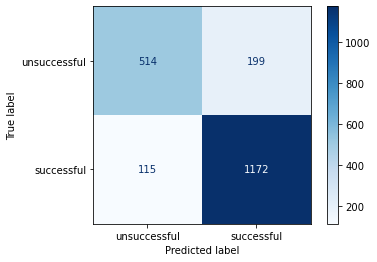

In [10]:
np.random.seed(seed=2021)
pipe_knn = make_pipeline(pre_processor, KNeighborsClassifier())
pipe_knn.fit(X_train,y_train)
param_grid = {'kneighborsclassifier__n_neighbors':range(1, 100)}
random_search_knn= RandomizedSearchCV(pipe_knn, param_grid, n_jobs=-1, cv=5, return_train_score=True,n_iter=10)
random_search_knn.fit(X_train, y_train);
print('best parameters', random_search_knn.best_params_)
print('best model train score',random_search_knn.best_estimator_.score(X_train,y_train))
print('best model test score',random_search_knn.best_estimator_.score(X_test,y_test))
plot_confusion_matrix(pipe_knn, X_test, y_test,display_labels=["unsuccessful", "successful"],values_format="d", cmap="Blues");

### Model: Logistic regression

best parameter {'logisticregression__C': 97.49293061113849}
best model train score 0.95125
best model test score 0.9355


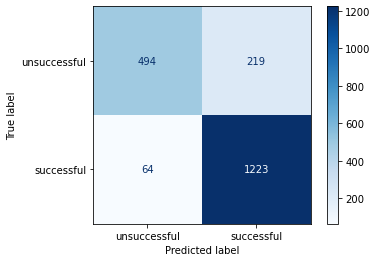

In [11]:
pipe_logistic_reg = make_pipeline(pre_processor, LogisticRegression(max_iter = 1000))
pipe_logistic_reg.fit(X_train,y_train)
param_grid = {'logisticregression__C':loguniform(0.01, 100)}
random_search_logistic_reg = RandomizedSearchCV(pipe_logistic_reg, param_grid, n_jobs=-1, cv=10, return_train_score=True,n_iter=10,
                                               random_state = 2021)
random_search_logistic_reg.fit(X_train, y_train);
print('best parameter', random_search_logistic_reg.best_params_)
print('best model train score',random_search_logistic_reg.best_estimator_.score(X_train,y_train))
print('best model test score',random_search_logistic_reg.best_estimator_.score(X_test,y_test))
plot_confusion_matrix(pipe_logistic_reg, X_test, y_test,display_labels=["unsuccessful", "successful"],
                      values_format="d", cmap="Blues");

### Model: DecisionTreeClassifier

best parameter {'decisiontreeclassifier__max_depth': 8}
best model train score 0.989875
best model test score 0.9795


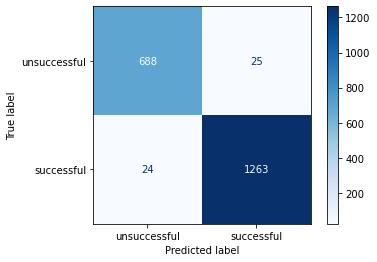

In [12]:
pipe_decision_tree_clf= make_pipeline(pre_processor, DecisionTreeClassifier())
pipe_decision_tree_clf.fit(X_train,y_train)
param_grid = {'decisiontreeclassifier__max_depth':range(0,100)}
random_search_decision_tree_clf = RandomizedSearchCV(pipe_decision_tree_clf, param_grid, n_jobs=-1, cv=10, return_train_score=True,n_iter=10,
                                                    random_state = 2021)
random_search_decision_tree_clf.fit(X_train, y_train);
print('best parameter', random_search_decision_tree_clf.best_params_)
print('best model train score',random_search_decision_tree_clf.best_estimator_.score(X_train,y_train))
print('best model test score',random_search_decision_tree_clf.best_estimator_.score(X_test,y_test))
plot_confusion_matrix(pipe_decision_tree_clf, X_test, y_test,display_labels=["unsuccessful", "successful"],
                      values_format="d", cmap="Blues");

### Model: Support Vector Machine Classifier

best parameters {'svc__C': 97.49293061113849, 'svc__gamma': 0.032557383985590826}
best model train score 0.9285
best model test score 0.906


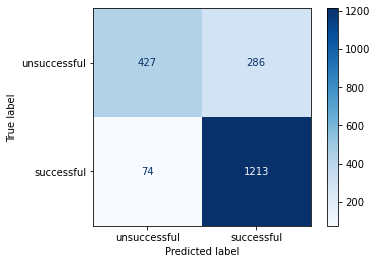

In [13]:
pipe_SVC = make_pipeline(pre_processor, SVC())
pipe_SVC.fit(X_train,y_train)
param_grid = {
    'svc__gamma':loguniform(0.01, 100),
    'svc__C':loguniform(0.01, 100)
}
random_search_SVC = RandomizedSearchCV(pipe_SVC, param_grid, n_jobs=-1, cv=10, return_train_score=True,n_iter=10,
                                      random_state = 2021)
random_search_SVC.fit(X_train, y_train);
print('best parameters', random_search_SVC.best_params_)
print('best model train score',random_search_SVC.best_estimator_.score(X_train,y_train))
print('best model test score',random_search_SVC.best_estimator_.score(X_test,y_test))
plot_confusion_matrix(pipe_SVC, X_test, y_test,display_labels=["unsuccessful", "successful"],
                      values_format="d", cmap="Blues");

In [14]:
# Summary of model performance:
print("K Nearest Neighbors:",classification_report(y_test, pipe_knn.predict(X_test),target_names=["successful", "unsuccessful"],digits=4))
print("Logistic Model:",classification_report(y_test, pipe_logistic_reg.predict(X_test),target_names=["successful", "unsuccessful"],digits=4))
print("Decision Tree:",classification_report(y_test, pipe_decision_tree_clf.predict(X_test),target_names=["successful", "unsuccessful"],digits=4))
print("SVC:",classification_report(y_test, pipe_SVC.predict(X_test),target_names=["successful", "unsuccessful"],digits=4))

K Nearest Neighbors:               precision    recall  f1-score   support

  successful     0.8172    0.7209    0.7660       713
unsuccessful     0.8549    0.9106    0.8819      1287

    accuracy                         0.8430      2000
   macro avg     0.8360    0.8158    0.8239      2000
weighted avg     0.8414    0.8430    0.8406      2000

Logistic Model:               precision    recall  f1-score   support

  successful     0.8853    0.6928    0.7773       713
unsuccessful     0.8481    0.9503    0.8963      1287

    accuracy                         0.8585      2000
   macro avg     0.8667    0.8216    0.8368      2000
weighted avg     0.8614    0.8585    0.8539      2000

Decision Tree:               precision    recall  f1-score   support

  successful     0.9663    0.9649    0.9656       713
unsuccessful     0.9806    0.9814    0.9810      1287

    accuracy                         0.9755      2000
   macro avg     0.9734    0.9731    0.9733      2000
weighted avg     0.975

### Model results and model selection

We have already built four models and performed hyperparameter optimization and obtained four best models, one for each classifier type. We create the following table to record performances of this four models with best-performing parameters. The precision, recall and f1-score included are in the form of weighted average, because we want to give equal weight to all observations, regardless of their true class labels.

From this table we can see that all these 4 models are doing significantly better than dummyClassifier, which gives a training score at ~53% and test score at ~52%. Among all these performance metrics, we decided to use f1 score as the criterion for comparing models. As a harmonic mean for precision and recall, f1 avoids the trade-off between this two and a higher f1 score is a fair indication that the model performs well. (We don't have a significant class imbalance in this case, so just using accuracy is also fine)

The final model we choose is the $Decision Tree classifier$, with the depth of 8. It fits the training set very well with an accuracy 98%+ but it does not overfit, providing also a really high test score ~97% by predict with the best decision tree model against the test set. Our final model is relatively easy to interpret: with max_depth =8, it is a simple model.

| Model| train score|test score|precision |recall|f1 socre|
| --- | ----------- | ------|-------|-----|-----|
| KNN | 0.872375 |0.842|0.8414|0.8430|0.8406 |
| Logistic Regression | 0.95125 |0.9355|0.8614 |0.8585|0.8539|
| Decision Tree Classifier | 0.989875 |0.9795|0.9755|0.9755|0.9755|
| SVC | 0.9285 |0.906|0.82469|0.8200|0.8111|


# Communication of Results, and Non-expert Advice:

The model we built can predict the final state of a project by putting features of interest to the model. Once the model has the information of a project, it will examine each of the project’s features and make a series of decisions to classify it as “successful” or “unsuccessful” with an accuracy of over 95%.
To answer the business question of whether a specific project is worth investing in, we need to know if the feature/feature combinations provided contribute enough to the prediction of the final state. 
Different feature combinations will provide different prediction results. By checking the predicted results, clients will have a general idea of whether a project is worth investing in or not.


# Reference:

Wikimedia Foundation. (2021, April 3). Kickstarter. Wikipedia. https://en.wikipedia.org/wiki/Kickstarter.